In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datetime import datetime

# yahoo Finance API library (useful?)
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as pdr
yf.pdr_override()

In [2]:
stock = 'INTC'

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

globals()[stock] = yf.download(stock, start, end)

df_intc = globals()[stock]


[*********************100%%**********************]  1 of 1 completed


In [3]:
window_size = 60

# Define the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(window_size, 1)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

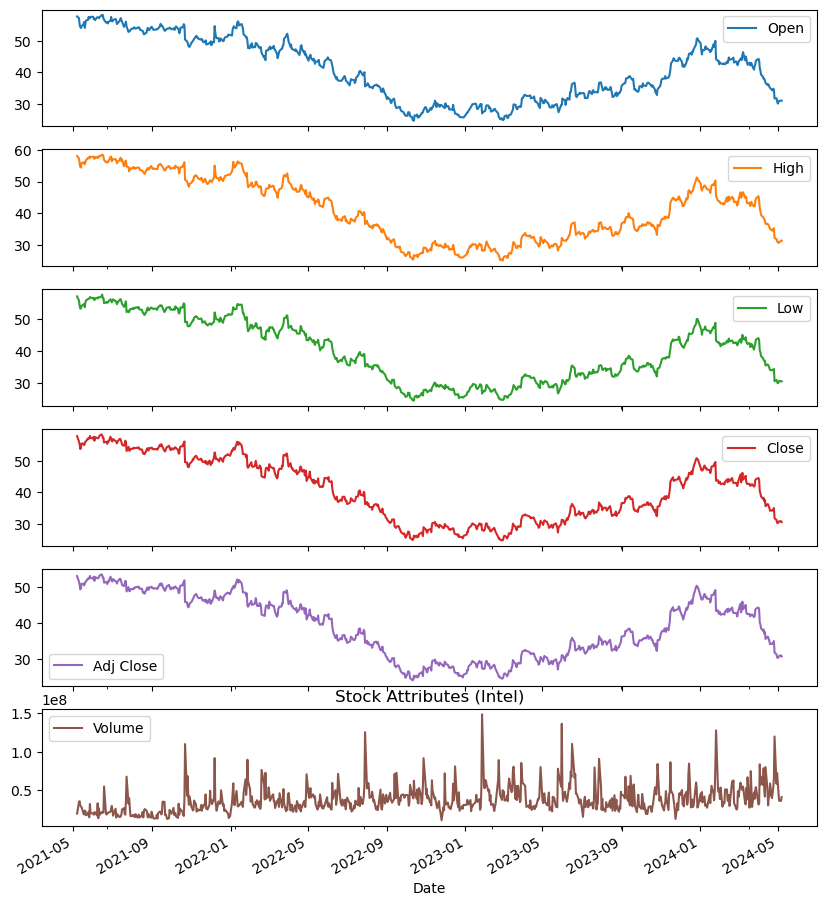

In [4]:
df_intc.plot(subplots = True, figsize=(10,12))
plt.title("Stock Attributes (Intel)")
plt.show()

In [5]:
fig = px.line(df_intc, y=['Open', 'Close', 'High', 'Low', 'Adj Close'], title = 'Date vs Stock Prices')
fig.show()

It is seen that Intel has had a rocky performance reaching a low of $24 in October 2022. Having a recovery in December 2023 but leading to another drop in stock price in April 2024.

In [6]:
fig = px.line(df_intc, y=['Volume'], title = 'Date vs Stock Prices')
fig.show()

In [ ]:
# intc Candlestick Chart

fig = go.Figure(data=[go.Candlestick(x=df_intc.index, open=df_intc['Open'], high=df_intc['High'], low=df_intc['Low'], close=df_intc['Close'])])

fig.update_layout(title='Intel Stock Price Candlestick Chart', xaxis_title='Date', yaxis_title='Stock Price (USD)')
fig.show()

In [ ]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_intc[column_name] = df_intc['Adj Close'].rolling(ma).mean()

df_intc[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title("intc Moving Averages")

In [ ]:
df_intc['Daily Return'] = df_intc['Adj Close'].pct_change()
df_intc['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('intc Daily Return')

### Prediction for Intel

In [ ]:
start = datetime(end.year - 5, end.month, end.day)
df_intc = pdr.get_data_yahoo('INTC', start=start, end=end)

X = df_intc[['High', 'Low', 'Open']]  # Features
y = df_intc['Close']  # Target variable

data = df_intc.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .95))

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

X, y = [], []
for i in range(len(scaled_data) - window_size):
    X.append(scaled_data[i:i+window_size])
    y.append(scaled_data[i+window_size])

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)

# data set for within 60 days
test_data = scaled_data[training_data_len - 60: , :]
test_set = []
for i in range(60, len(test_data)):
    test_set.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
test_set = np.array(test_set)

# Reshape the data
test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1 ))

prediction = model.predict(test_set)
scaled_pred = scaler.inverse_transform(prediction)

valid = data[training_data_len:]
valid['Predictions'] = scaled_pred